In [1]:
import json, copy, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Validation Data

Key findings from research to be recreated in SIMOC.

In [2]:
# --------
# Severinghaus et al. Atmospheric Budget for Biosphere 2,  
# Sept. 26, 1991 - June 7, 1993
# --------

# Daily o2 and co2 data, estimated from graphic (p1) using WebPlotDigitizer
data_files_path = 'simoc_server/test/b2_data_files/'
fnames = [('o2', 'severinghaus_o2_datapoints.csv'), 
          ('co2', 'severinghaus_co2_datapoints.csv'),
          ('co2_in_scrubber', 'severinghaus_co2_offset_datapoints.csv')]
mission_1a_start_date = '1991-09-26'
daily_o2_co2 = pd.DataFrame([])
for var, fname in fnames:
    df = pd.read_csv(data_files_path + fname, header=None)
    df.columns = ['julian', 'value']
    df['label'] = var
    df['timestamp'] = pd.to_datetime(mission_1a_start_date)  # Create timestamp column
    time_delta = pd.to_timedelta(df['julian'], unit='D')  # julian -> timedelta
    df['timestamp'] += time_delta  # Add timedelta to timestamp
    del df['julian']
    daily_o2_co2 = pd.concat([daily_o2_co2, df], axis=0)  # Add to all records
daily_o2_co2.set_index('timestamp', inplace=True)
print('Daily o2 and co2 data:', daily_o2_co2.shape, daily_o2_co2['label'].unique())

# Table 1: Known inputs and outputs
cols = ['description', 'o2_kmoles', 'o2_uncertainty', 'co2_kmoles', 'co2_uncertainty']
data = [('Air added on day 75', 126, 4, 0, 0),
        ('Air dumped on day 474', -31, 2, -1, 1),
        ('Pure O2 added on days 475-494', 441, 8, 0, 0),
        ('Total CO2 taken up by scrubber', 0, 0, -98, 10),
        ('Estimated net leakage', 2, 24, -2, 1),
        ('Soil Respiration', -708, 27, 662, 40),
        ('Concrete Calcification', 0, 0, -550, 38),]
aggregate_flows = pd.DataFrame(data, columns=cols)
print('Aggregate o2 and co2 flows:', aggregate_flows.shape)

# --------
# Marino et. al. The Agricultural biome of Biosphere 2: Structure, 
# composition and function
# --------

# Page 202: Design and description
iab_soil_volume = 2_000  # m2
cols = ['plot', 'area', 'crop']
data = [
    # Plot, area, crop
    (1, 69, 'Rice/Azalia/Tilapia'),
    (2, 56, 'Wheat'),
    (3, 55, 'Sorghum'),
    (4, 45, 'Peanut/Corn'),
    (5, 40, 'Beans'),
    (6, 52, 'Sweet Potato'),
    (7, 54, 'Sweet Potato'),
    (8, 50, 'Beans'),
    (9, 60, 'Vegetables'),
    (10, 89, 'Rice/Azalia/Tilapia'),
    (11, 81, 'Soybeans'),
    (12, 88, 'Corn'),
    (13, 94, 'Wheat'),
    (14, 81, 'Vegetables'),
    (15, 78, 'Rice'),
    (16, 83, 'Upland Rice/Corn'),
    (17, 102, 'Soybean/Sorghum'),
    (18, 92, 'Peanut/Corn')]
greenhouse_layout = pd.DataFrame(data, columns=cols)
greenhouse_layout.set_index('plot', inplace=True)
print('Greenhouse Layout:', greenhouse_layout.shape)

# p214: "By the last quarter of Mission 1, approximately 65% of the 
# agricultural area was planted in only three crops: beet, sweet potato 
# and lab-lab bean."
mission_2_staple_ratio = 0.65

# Page 220: Comparisons of plant productivity for selected IAB and CELSS crops
cols = ['mission', 'wheat', 'rice', 'corn', 'sorghum']
data = [('1a', 0.0017, 0.0023, 0, 0.0017),
       ('1b', .0012, 0.0016, 0, 0.0016),
       ('2', 0.003, 0.006, 0.0039, 0.0038)]
production_rates = pd.DataFrame(data, columns=cols)
print('Production Rates:', production_rates.shape, production_rates.columns)

Daily o2 and co2 data: (159, 2) ['o2' 'co2' 'co2_in_scrubber']
Aggregate o2 and co2 flows: (7, 5)
Greenhouse Layout: (18, 2)
Production Rates: (3, 5) Index(['mission', 'wheat', 'rice', 'corn', 'sorghum'], dtype='object')


### Load Data Files

Data files are generated via scripts in `agent_model/generate_b2_data_files.py`. 

We use the current SIMOC data files where available, with minimal adjustments (for now).

In [3]:
# Helper Func
data_files_path = 'data_files/b2/'
def load_data(fname):
    fpath = f'{data_files_path}{fname}.json'
    data = None
    with open(fpath) as f:
        data = json.load(f)
    return data

b2_currency_desc = load_data('currency_desc')
b2_agent_desc = load_data('agent_desc')
b2_agent_conn = load_data('agent_conn')
print('Agents:', {k: list(v.keys()) for k, v in b2_agent_desc.items()})
print('Currencies:', {k: list(v.keys()) for k, v in b2_currency_desc.items()})

Agents: {'inhabitants': ['human_agent'], 'eclss': ['co2_removal', 'o2_makeup_valve'], 'plants': ['rice', 'wheat', 'sweet_potato', 'soybean', 'peanut', 'dry_bean'], 'structures': ['b2_greenhouse', 'b2_crew_habitat', 'b2_biomes', 'atm_eq_gh_crew', 'atm_eq_gh_biomes', 'soil', 'concrete'], 'storage': ['water_storage', 'food_storage', 'nutrient_storage', 'co2_storage', 'o2_storage']}
Currencies: {'atmosphere': ['o2', 'co2', 'h2', 'n2', 'h2o', 'ch4'], 'nutrients': ['fertilizer', 'waste', 'biomass', 'inedible_biomass'], 'food': ['rice', 'wheat', 'dry_bean', 'peanut', 'soybean', 'sweet_potato'], 'water': ['treated', 'potable', 'urine', 'feces']}


### Edit Data Files

Workspace for fine-tuning model parameters

### Run in SIMOC

In [4]:
from agent_model import AgentModel
import time

missions = ('1a', '1b', '2')
mission_data = {m: None for m in missions}
for mission in missions:
    # Load the correct config
    config = load_data(f'config_mission_{mission}')
    
    # Build the model, run it to termination and export data
    simoc = AgentModel.from_config(
        config, 
        data_collection=True,
        currency_desc=b2_currency_desc,
        agent_desc=b2_agent_desc,
        agent_conn=b2_agent_conn,
        agent_variation=None,
        agent_events=None,
        merge=False
    )
    start_time = time.time()
    simoc.step_to(termination=True, max_steps=500*24)  # Mission 1a (longest) is 475 days
    mission_data[mission] = simoc.get_data(debug=True)
    print(f'Mission {mission}: {simoc.step_num} steps in {time.time()-start_time} s')

Mission 1a: 11400 steps in 15.548986911773682 s
Mission 1b: 6168 steps in 8.751343727111816 s
Mission 2: 4440 steps in 6.281491994857788 s


### Compare Model Data to Validation

For each variable, compare the data generated by SIMOC to the validation data.

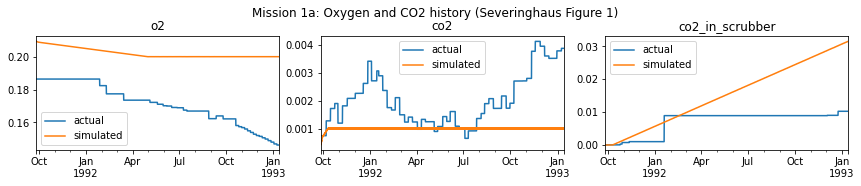

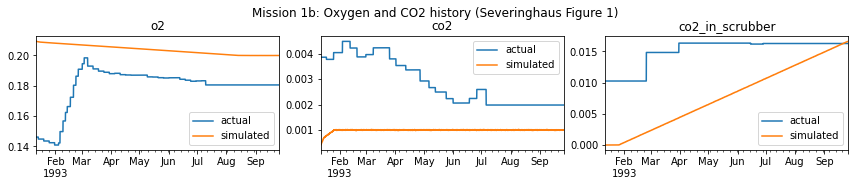

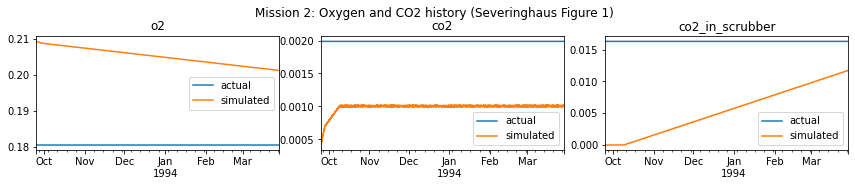

In [5]:
# Atmosphere
for mission in ('1a', '1b', '2'):
    start_date = {
        '1a': '1991-09-26',
        '1b': '1993-01-12',
        '2': '1993-09-25',
    }[mission]
    data = mission_data[mission]
    n_steps = len(data['b2_greenhouse']['age'])
    timesteps = pd.date_range(start_date, periods=n_steps, freq='H')
    def to_timesteps(df, value_col='percent'):
        """Return interpolated timestep values from a df of timestamped values"""
        ts = pd.DataFrame([], index=timesteps)  # Create a new df with timestep index
        for col in df.columns:
            ts[col] = df.loc[df.index[0], col]  # Fill with copies of the df[0]

        vals = ts[value_col].to_numpy()
        for i, row in df.iterrows():
            # Find the nearest timestep for every datapoint
            i_ts = ts.index.get_indexer([i], method='nearest')[0]
            # Set that step and all future steps to itself
            vals[i_ts:] = row[value_col]    
        ts[value_col] = vals
        return ts

    # 3-panel: o2, co2, co2 in scrubber
    fig, axs = plt.subplots(1, 3, figsize=(12, 2.5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    fig.suptitle(f'Mission {mission}: Oxygen and CO2 history (Severinghaus Figure 1)')
    for i, field in enumerate(daily_o2_co2['label'].unique()):

        # Put the model data in a dataframe with a time axis
        if field == 'co2_in_scrubber':
            simulated = np.array(data['co2_storage']['storage']['co2'])
            # Divide by the total starting mass of b2_greenhouse for percentage
            greenhouse_atmosphere = sum([data['b2_greenhouse']['storage'][currency][0]
                                         for currency in data['b2_greenhouse']['storage']])
            simulated /= greenhouse_atmosphere
        else:
            simulated = np.array(data['b2_greenhouse']['storage_ratios'][field])
        # TODO: Convert kg ratio to mole ratio
        sim_ts = pd.DataFrame(simulated, index=timesteps, columns=['percent'])
        sim_ts['label'] = 'simulated'

        # Select sample data for mission
        actual = daily_o2_co2[daily_o2_co2['label'] == field]
        actual = actual[actual.index <= timesteps[-1]]  # Set range
        act_raw = pd.DataFrame(actual['value'].to_numpy(), 
                               index=actual.index, columns=['percent'])
        act_raw['label'] = 'actual'
        act_ts = to_timesteps(act_raw)

        # Plot both on the axis
        df = pd.concat([sim_ts, act_ts], axis=0)
        df.groupby('label').percent.plot(legend=True, title=field, ax=axs[i])

In [30]:
from agent_model.util import parse_data

# Aggregate gas flows
actual = aggregate_flows[['description', 'o2_kmoles', 'co2_kmoles']]
print('Actual:\n', actual)
print('\nSimulated:')

# 'Air added on day 75' (ignore)
# 'Air dumped on day 474' (ignore)
# 'Pure O2 added on days 475-494'
i_start, i_end = 474*24 + 1, 494*24
path = ['o2_makeup_valve', 'flows', 'o2', f'{i_start}:{i_end}']
o2added = parse_data(mission_data['1a'], path)
print('  o2 Added:', round(sum(o2added), 2))

# 'Total CO2 taken up by scrubber'
path = ['co2_storage', 'storage', 'co2', '*']
co2scrubbed = parse_data(mission_data['1a'], path)[-1]
print('  co2 Scrubbed:', round(co2scrubbed, 2))

# 'Estimated net leakage' ('ignore')
# 'Soil Respiration'
path = ['soil', 'flows', 'o2,co2', '*']
respiration = parse_data(mission_data['1a'], path)
respiration = {k: round(sum(v), 2) for k, v in respiration.items()}
print('  Soil Respiration:', respiration)

# 'Concrete Calcification'
path = ['concrete', 'flows', 'o2,co2', '*']
calcification = parse_data(mission_data['1a'], path)
calcification = {k: round(sum(v), 2) for k, v in calcification.items()}
print('  Concrete Calcification:', calcification)



Actual:
                       description  o2_kmoles  co2_kmoles
0             Air added on day 75        126           0
1           Air dumped on day 474        -31          -1
2   Pure O2 added on days 475-494        441           0
3  Total CO2 taken up by scrubber          0         -98
4           Estimated net leakage          2          -2
5                Soil Respiration       -708         662
6          Concrete Calcification          0        -550

Simulated:
  o2 Added: 0.85
  co2 Scrubbed: 221.26
  Soil Respiration: {'o2': 422.75, 'co2': 513.0}
  Concrete Calcification: {'co2': 285.0}


label
co2                AxesSubplot(0.125,0.2;0.775x0.68)
co2_in_scrubber    AxesSubplot(0.125,0.2;0.775x0.68)
o2                 AxesSubplot(0.125,0.2;0.775x0.68)
Name: moles, dtype: object

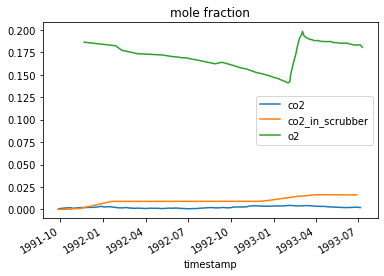

In [7]:
# Severinghaus et al. Atmospheric Budget for Biosphere 2,  Sept. 26, 1991 - June 7, 1993
# Daily o2 and co2 data, estimated from graphic (p1)
data_files_path = 'simoc_server/test/b2_data_files/'
fnames = [('o2', 'severinghaus_o2_datapoints.csv'), 
          ('co2', 'severinghaus_co2_datapoints.csv'),
          ('co2_in_scrubber', 'severinghaus_co2_offset_datapoints.csv')]
moles = pd.DataFrame([])
for var, fname in fnames:
    df = pd.read_csv(data_files_path + fname, header=None)
    df.columns = ['julian', 'moles']
    df['label'] = var
    
    df['timestamp'] = pd.to_datetime(mission_1a_start_date)  # Create timestamp column
    time_delta = pd.to_timedelta(df['julian'], unit='D')  # julian -> timedelta
    df['timestamp'] += time_delta  # Add timedelta to timestamp
    moles = pd.concat([moles, df], axis=0)  # Add to all records
    
    
moles.set_index('timestamp').groupby('label').moles.plot(
    legend=True, title='mole fraction')

<Figure size 432x288 with 0 Axes>

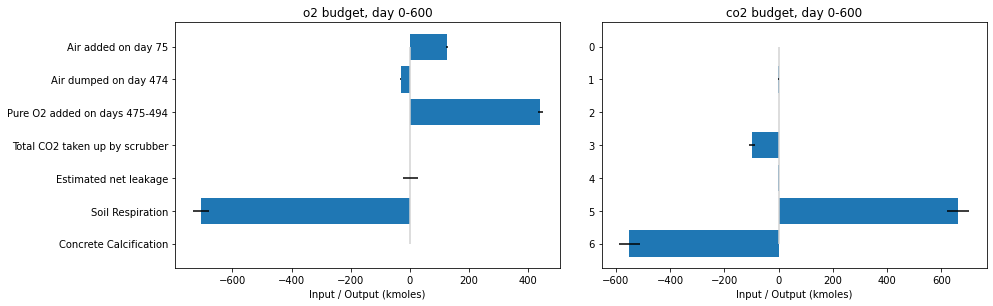

In [8]:
# Severignhaus et al. Atmospheric Budget for Biosphere 2,  Sept. 26, 1991 - June 7, 1993
# Table 1: Known inputs and outputs
cols = ['description', 'o2_kmoles', 'o2_uncertainty', 'co2_kmoles', 'co2_uncertainty']
data = [('Air added on day 75', 126, 4, 0, 0),
        ('Air dumped on day 474', -31, 2, -1, 1),
        ('Pure O2 added on days 475-494', 441, 8, 0, 0),
        ('Total CO2 taken up by scrubber', 0, 0, -98, 10),
        ('Estimated net leakage', 2, 24, -2, 1),
        ('Soil Respiration', -708, 27, 662, 40),
        ('Concrete Calcification', 0, 0, -550, 38),]
table_1 = pd.DataFrame(data, columns=cols)
table_1.head()

plt.subplots_adjust(wspace=10)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
y_pos = range(table_1.shape[0])
for i, currency in enumerate(('o2', 'co2')):
    ax[i].vlines(0, 0, 6, colors='lightgray')
    ax[i].barh(y_pos, 
               table_1[f'{currency}_kmoles'], 
               xerr=table_1[f'{currency}_uncertainty'], 
               align='center')
    if i == 0:
        ax[i].set_yticks(y_pos, labels=table_1['description'])
    ax[i].invert_yaxis()  # labels read top-to-bottom
    ax[i].set_xlabel('Input / Output (kmoles)')
    ax[i].set_title(f'{currency} budget, day 0-600')